In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade, automated_readability_index
import spacy
from wordcloud import WordCloud
import pickle
import os
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)


True

In [21]:
# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Please install spaCy English model: python -m spacy download en_core_web_sm")

# Set up paths
BASE_PATH = "/home/ghost/fake-news-game-theory/data"
RAW_PATH = os.path.join(BASE_PATH, "raw")
PROCESSED_PATH = os.path.join(BASE_PATH, "processed")

# Create processed subfolders if they don't exist
for folder in ['features', 'train', 'test', 'validation']:
    os.makedirs(os.path.join(PROCESSED_PATH, folder), exist_ok=True)

print("Feature Engineering Pipeline Initialized")
print(f"Raw data path: {RAW_PATH}")
print(f"Processed data path: {PROCESSED_PATH}")

Please install spaCy English model: python -m spacy download en_core_web_sm
Feature Engineering Pipeline Initialized
Raw data path: /home/ghost/fake-news-game-theory/data/raw
Processed data path: /home/ghost/fake-news-game-theory/data/processed


In [22]:
## 1. Data Loading and Exploration

def load_datasets():
    """Load all available datasets"""
    datasets = {}
    
    # Load FakeNewsNet data
    fakenewsnet_path = os.path.join(RAW_PATH, "fakenewsnet")
    if os.path.exists(fakenewsnet_path):
        datasets['gossipcop_fake'] = pd.read_csv(os.path.join(fakenewsnet_path, "gossipcop_fake.csv"))
        datasets['gossipcop_real'] = pd.read_csv(os.path.join(fakenewsnet_path, "gossipcop_real.csv"))
        datasets['politifact_fake'] = pd.read_csv(os.path.join(fakenewsnet_path, "politifact_fake.csv"))
        datasets['politifact_real'] = pd.read_csv(os.path.join(fakenewsnet_path, "politifact_real.csv"))
        print("✓ FakeNewsNet datasets loaded")
    
    # Load Kaggle dataset
    kaggle_path = os.path.join(RAW_PATH, "kaggle_fake_news")
    if os.path.exists(kaggle_path):
        datasets['kaggle_fake'] = pd.read_csv(os.path.join(kaggle_path, "Fake.csv"))
        datasets['kaggle_real'] = pd.read_csv(os.path.join(kaggle_path, "True.csv"))
        print("✓ Kaggle datasets loaded")
    
    # Load LIAR dataset
    liar_path = os.path.join(RAW_PATH, "liar_dataset")
    if os.path.exists(liar_path):
        # LIAR has TSV format with specific column structure
        liar_columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 
                       'state', 'party', 'barely_true_count', 'false_count', 
                       'half_true_count', 'mostly_true_count', 'pants_on_fire_count', 'context']
        
        datasets['liar_train'] = pd.read_csv(os.path.join(liar_path, "train.tsv"), 
                                           sep='\t', names=liar_columns, header=None)
        datasets['liar_test'] = pd.read_csv(os.path.join(liar_path, "test.tsv"), 
                                          sep='\t', names=liar_columns, header=None)
        datasets['liar_valid'] = pd.read_csv(os.path.join(liar_path, "valid.tsv"), 
                                           sep='\t', names=liar_columns, header=None)
        print("✓ LIAR datasets loaded")
    
    return datasets

# Load datasets
datasets = load_datasets()

✓ FakeNewsNet datasets loaded
✓ Kaggle datasets loaded
✓ LIAR datasets loaded


In [23]:
# Display dataset information
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.columns.tolist()}")
    print(f"  Sample:\n{df.head(2)}")



gossipcop_fake:
  Shape: (5323, 4)
  Columns: ['id', 'news_url', 'title', 'tweet_ids']
  Sample:
                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   

                                               title  \
0  Did Miley Cyrus and Liam Hemsworth secretly ge...   
1  Paris Jackson & Cara Delevingne Enjoy Night Ou...   

                                           tweet_ids  
0  284329075902926848\t284332744559968256\t284335...  
1  992895508267130880\t992897935418503169\t992899...  

gossipcop_real:
  Shape: (16817, 4)
  Columns: ['id', 'news_url', 'title', 'tweet_ids']
  Sample:
                 id                                           news_url  \
0  gossipcop-882573  https://www.brides.com/story/teen-mom-jenelle-...   
1  gossipcop-875924  https://www.dailymail.co.uk/tvshowbiz/article-...   

           

In [24]:
## 2. Advanced Text Feature Extraction

class AdvancedTextFeatures:
    """Extract comprehensive text features for fake news detection"""
    
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()
        self.label_encoder = LabelEncoder()
        
    def extract_linguistic_features(self, texts):
        """Extract linguistic features from text"""
        features = []
        
        for text in texts:
            if pd.isna(text) or text == '':
                # Handle missing text
                features.append({
                    'char_count': 0,
                    'word_count': 0,
                    'sentence_count': 0,
                    'avg_word_length': 0,
                    'avg_sentence_length': 0,
                    'punctuation_count': 0,
                    'capital_letter_count': 0,
                    'exclamation_count': 0,
                    'question_count': 0,
                    'readability_score': 0,
                    'grade_level': 0,
                    'sentiment_positive': 0,
                    'sentiment_negative': 0,
                    'sentiment_neutral': 0,
                    'sentiment_compound': 0
                })
                continue
                
            text = str(text)
            
            # Basic counts
            char_count = len(text)
            words = text.split()
            word_count = len(words)
            sentences = text.split('.')
            sentence_count = len([s for s in sentences if s.strip()])
            
            # Average lengths
            avg_word_length = np.mean([len(word) for word in words]) if words else 0
            avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
            
            # Character analysis
            punctuation_count = sum(1 for char in text if char in '.,!?;:')
            capital_letter_count = sum(1 for char in text if char.isupper())
            exclamation_count = text.count('!')
            question_count = text.count('?')
            
            # Readability scores
            try:
                readability_score = flesch_reading_ease(text)
                grade_level = flesch_kincaid_grade(text)
            except:
                readability_score = 0
                grade_level = 0
            
            # Sentiment analysis
            sentiment_scores = self.sia.polarity_scores(text)
            
            features.append({
                'char_count': char_count,
                'word_count': word_count,
                'sentence_count': sentence_count,
                'avg_word_length': avg_word_length,
                'avg_sentence_length': avg_sentence_length,
                'punctuation_count': punctuation_count,
                'capital_letter_count': capital_letter_count,
                'exclamation_count': exclamation_count,
                'question_count': question_count,
                'readability_score': readability_score,
                'grade_level': grade_level,
                'sentiment_positive': sentiment_scores['pos'],
                'sentiment_negative': sentiment_scores['neg'],
                'sentiment_neutral': sentiment_scores['neu'],
                'sentiment_compound': sentiment_scores['compound']
            })
        
        return pd.DataFrame(features)
    
    def extract_pos_features(self, texts):
        """Extract Part-of-Speech features"""
        pos_features = []
        
        for text in texts:
            if pd.isna(text) or text == '':
                pos_features.append({
                    'noun_ratio': 0,
                    'verb_ratio': 0,
                    'adj_ratio': 0,
                    'adv_ratio': 0,
                    'pronoun_ratio': 0,
                    'preposition_ratio': 0,
                    'conjunction_ratio': 0,
                    'interjection_ratio': 0
                })
                continue
                
            text = str(text)
            
            try:
                # Process with spaCy
                doc = nlp(text)
                
                # Count POS tags
                pos_counts = Counter([token.pos_ for token in doc])
                total_tokens = len(doc)
                
                pos_features.append({
                    'noun_ratio': pos_counts.get('NOUN', 0) / total_tokens if total_tokens > 0 else 0,
                    'verb_ratio': pos_counts.get('VERB', 0) / total_tokens if total_tokens > 0 else 0,
                    'adj_ratio': pos_counts.get('ADJ', 0) / total_tokens if total_tokens > 0 else 0,
                    'adv_ratio': pos_counts.get('ADV', 0) / total_tokens if total_tokens > 0 else 0,
                    'pronoun_ratio': pos_counts.get('PRON', 0) / total_tokens if total_tokens > 0 else 0,
                    'preposition_ratio': pos_counts.get('ADP', 0) / total_tokens if total_tokens > 0 else 0,
                    'conjunction_ratio': pos_counts.get('CCONJ', 0) / total_tokens if total_tokens > 0 else 0,
                    'interjection_ratio': pos_counts.get('INTJ', 0) / total_tokens if total_tokens > 0 else 0
                })
            except:
                # Fallback if spaCy fails
                pos_features.append({
                    'noun_ratio': 0,
                    'verb_ratio': 0,
                    'adj_ratio': 0,
                    'adv_ratio': 0,
                    'pronoun_ratio': 0,
                    'preposition_ratio': 0,
                    'conjunction_ratio': 0,
                    'interjection_ratio': 0
                })
        
        return pd.DataFrame(pos_features)
    
    def extract_named_entity_features(self, texts):
        """Extract Named Entity features"""
        ne_features = []
        
        for text in texts:
            if pd.isna(text) or text == '':
                ne_features.append({
                    'person_entities': 0,
                    'org_entities': 0,
                    'gpe_entities': 0,
                    'money_entities': 0,
                    'date_entities': 0,
                    'time_entities': 0,
                    'percent_entities': 0,
                    'total_entities': 0
                })
                continue
                
            text = str(text)
            
            try:
                doc = nlp(text)
                
                # Count entity types
                entity_counts = Counter([ent.label_ for ent in doc.ents])
                
                ne_features.append({
                    'person_entities': entity_counts.get('PERSON', 0),
                    'org_entities': entity_counts.get('ORG', 0),
                    'gpe_entities': entity_counts.get('GPE', 0),
                    'money_entities': entity_counts.get('MONEY', 0),
                    'date_entities': entity_counts.get('DATE', 0),
                    'time_entities': entity_counts.get('TIME', 0),
                    'percent_entities': entity_counts.get('PERCENT', 0),
                    'total_entities': len(doc.ents)
                })
            except:
                ne_features.append({
                    'person_entities': 0,
                    'org_entities': 0,
                    'gpe_entities': 0,
                    'money_entities': 0,
                    'date_entities': 0,
                    'time_entities': 0,
                    'percent_entities': 0,
                    'total_entities': 0
                })
        
        return pd.DataFrame(ne_features)

In [25]:
## 3. Preprocessing and Feature Engineering Pipeline

def preprocess_fakenewsnet_data(datasets):
    """Preprocess FakeNewsNet datasets"""
    processed_data = []
    
    # Process GossipCop data
    if 'gossipcop_fake' in datasets and 'gossipcop_real' in datasets:
        # Fake news
        fake_data = datasets['gossipcop_fake'].copy()
        fake_data['label'] = 0  # Fake
        fake_data['domain'] = 'gossipcop'
        fake_data['text'] = fake_data['title'].fillna('')
        
        # Real news
        real_data = datasets['gossipcop_real'].copy()
        real_data['label'] = 1  # Real
        real_data['domain'] = 'gossipcop'
        real_data['text'] = real_data['title'].fillna('')
        
        processed_data.extend([fake_data, real_data])
    
    # Process PolitiFact data
    if 'politifact_fake' in datasets and 'politifact_real' in datasets:
        # Fake news
        fake_data = datasets['politifact_fake'].copy()
        fake_data['label'] = 0  # Fake
        fake_data['domain'] = 'politifact'
        fake_data['text'] = fake_data['title'].fillna('')
        
        # Real news
        real_data = datasets['politifact_real'].copy()
        real_data['label'] = 1  # Real
        real_data['domain'] = 'politifact'
        real_data['text'] = real_data['title'].fillna('')
        
        processed_data.extend([fake_data, real_data])
    
    if processed_data:
        combined_data = pd.concat(processed_data, ignore_index=True)
        # Keep only necessary columns
        columns_to_keep = ['text', 'label', 'domain']
        if 'tweet_ids' in combined_data.columns:
            columns_to_keep.append('tweet_ids')
        
        return combined_data[columns_to_keep]
    
    return pd.DataFrame()

def preprocess_kaggle_data(datasets):
    """Preprocess Kaggle datasets"""
    processed_data = []
    
    if 'kaggle_fake' in datasets and 'kaggle_real' in datasets:
        # Fake news
        fake_data = datasets['kaggle_fake'].copy()
        fake_data['label'] = 0  # Fake
        fake_data['domain'] = 'kaggle'
        # Combine title and text
        fake_data['text'] = (fake_data['title'].fillna('') + ' ' + 
                           fake_data['text'].fillna('')).str.strip()
        
        # Real news
        real_data = datasets['kaggle_real'].copy()
        real_data['label'] = 1  # Real
        real_data['domain'] = 'kaggle'
        # Combine title and text
        real_data['text'] = (real_data['title'].fillna('') + ' ' + 
                           real_data['text'].fillna('')).str.strip()
        
        processed_data.extend([fake_data, real_data])
    
    if processed_data:
        combined_data = pd.concat(processed_data, ignore_index=True)
        columns_to_keep = ['text', 'label', 'domain', 'subject', 'date']
        available_columns = [col for col in columns_to_keep if col in combined_data.columns]
        
        return combined_data[available_columns]
    
    return pd.DataFrame()

def preprocess_liar_data(datasets):
    """Preprocess LIAR datasets"""
    processed_data = []
    
    liar_datasets = ['liar_train', 'liar_test', 'liar_valid']
    
    for dataset_name in liar_datasets:
        if dataset_name in datasets:
            data = datasets[dataset_name].copy()
            
            # Convert multi-class labels to binary (for consistency)
            # pants-on-fire, false, barely-true -> 0 (fake)
            # half-true, mostly-true, true -> 1 (real)
            fake_labels = ['pants-on-fire', 'false', 'barely-true']
            data['label'] = data['label'].apply(lambda x: 0 if x in fake_labels else 1)
            
            data['domain'] = 'liar'
            data['text'] = data['statement'].fillna('')
            data['split'] = dataset_name.split('_')[1]  # train, test, valid
            
            processed_data.append(data)
    
    if processed_data:
        combined_data = pd.concat(processed_data, ignore_index=True)
        columns_to_keep = ['text', 'label', 'domain', 'subject', 'speaker', 
                          'job_title', 'state', 'party', 'split']
        available_columns = [col for col in columns_to_keep if col in combined_data.columns]
        
        return combined_data[available_columns]
    
    return pd.DataFrame()

# Preprocess all datasets
print("Preprocessing datasets...")

fakenewsnet_df = preprocess_fakenewsnet_data(datasets)
kaggle_df = preprocess_kaggle_data(datasets)
liar_df = preprocess_liar_data(datasets)

print(f"FakeNewsNet processed: {len(fakenewsnet_df)} rows")
print(f"Kaggle processed: {len(kaggle_df)} rows")
print(f"LIAR processed: {len(liar_df)} rows")

Preprocessing datasets...
FakeNewsNet processed: 23196 rows
Kaggle processed: 44898 rows
LIAR processed: 12791 rows


In [26]:
## 4. Feature Extraction

# Initialize feature extractor
feature_extractor = AdvancedTextFeatures()

def extract_all_features(df, dataset_name):
    """Extract all features for a dataset"""
    print(f"Extracting features for {dataset_name}...")
    
    if len(df) == 0:
        return pd.DataFrame()
    
    # Extract linguistic features
    print(f"  - Linguistic features...")
    linguistic_features = feature_extractor.extract_linguistic_features(df['text'])
    
    # Extract POS features
    print(f"  - POS features...")
    pos_features = feature_extractor.extract_pos_features(df['text'])
    
    # Extract Named Entity features
    print(f"  - Named Entity features...")
    ne_features = feature_extractor.extract_named_entity_features(df['text'])
    
    # Combine all features
    all_features = pd.concat([
        linguistic_features,
        pos_features,
        ne_features
    ], axis=1)
    
    # Add metadata
    all_features['label'] = df['label'].values
    all_features['domain'] = df['domain'].values
    all_features['text'] = df['text'].values
    
    # Add additional columns if available
    for col in ['subject', 'speaker', 'party', 'split']:
        if col in df.columns:
            all_features[col] = df[col].values
    
    return all_features

# Extract features for each dataset
all_features = []

if len(fakenewsnet_df) > 0:
    fakenewsnet_features = extract_all_features(fakenewsnet_df, "FakeNewsNet")
    all_features.append(fakenewsnet_features)

if len(kaggle_df) > 0:
    kaggle_features = extract_all_features(kaggle_df, "Kaggle")
    all_features.append(kaggle_features)

if len(liar_df) > 0:
    liar_features = extract_all_features(liar_df, "LIAR")
    all_features.append(liar_features)

# Combine all features
if all_features:
    combined_features = pd.concat(all_features, ignore_index=True, sort=False)
    print(f"Total combined features: {len(combined_features)} rows")
    print(f"Feature columns: {len(combined_features.columns)} columns")
else:
    print("No features extracted - check data loading")
    combined_features = pd.DataFrame()


Extracting features for FakeNewsNet...
  - Linguistic features...
  - POS features...
  - Named Entity features...
Extracting features for Kaggle...
  - Linguistic features...
  - POS features...
  - Named Entity features...
Extracting features for LIAR...
  - Linguistic features...
  - POS features...
  - Named Entity features...
Total combined features: 80885 rows
Feature columns: 38 columns


In [ ]:
## 5. Complete Feature Engineering Pipeline

def create_full_feature_matrix(combined_features, max_tfidf_features=1000):
    """Create complete feature matrix with linguistic + TF-IDF features"""
    print("Creating complete feature matrix...")
    
    # Extract linguistic features (already done in combined_features)
    feature_columns = [col for col in combined_features.columns 
                      if col not in ['text', 'label', 'domain', 'subject', 'speaker', 'party', 'split']]
    
    linguistic_features = combined_features[feature_columns].copy()
    print(f"Linguistic features: {linguistic_features.shape}")
    
    # Create TF-IDF features on a manageable subset for vocabulary
    print("Creating TF-IDF features...")
    clean_texts = [str(text) if not pd.isna(text) else '' for text in combined_features['text']]
    
    # Use smaller max_features to prevent memory issues
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_tfidf_features,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=5,  # Increased to reduce vocabulary
        max_df=0.85,  # Reduced to filter common words
        lowercase=True,
        strip_accents='ascii'
    )
    
    # Fit and transform TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_texts)
    feature_names = [f'tfidf_{name}' for name in tfidf_vectorizer.get_feature_names_out()]
    
    # Convert to DataFrame (use dense representation for smaller matrix)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    print(f"TF-IDF features: {tfidf_df.shape}")
    
    # Combine all features
    final_features = pd.concat([linguistic_features, tfidf_df], axis=1)
    
    # Add back metadata
    final_features['label'] = combined_features['label'].values
    final_features['domain'] = combined_features['domain'].values
    
    print(f"Final feature matrix: {final_features.shape}")
    
    return final_features, tfidf_vectorizer

if len(combined_features) > 0:
    try:
        # Create full feature matrix with smaller TF-IDF to prevent memory issues
        final_features, tfidf_vectorizer = create_full_feature_matrix(
            combined_features, 
            max_tfidf_features=1000  # Reduced for memory efficiency
        )
        
        print(f"✓ Feature matrix created successfully: {final_features.shape}")
        print(f"✓ Features: {final_features.shape[1]-2} (excluding label and domain)")
        print(f"✓ Samples: {final_features.shape[0]}")
        
        # Verify class distribution
        class_dist = final_features['label'].value_counts().sort_index()
        print(f"✓ Class distribution: {class_dist.to_dict()}")
        
    except Exception as e:
        print(f"Error in feature matrix creation: {e}")
        # Fallback to linguistic features only
        feature_columns = [col for col in combined_features.columns 
                          if col not in ['text', 'label', 'domain', 'subject', 'speaker', 'party', 'split']]
        
        final_features = combined_features[feature_columns + ['label', 'domain']].copy()
        tfidf_vectorizer = None
        
        print(f"Fallback to linguistic features only: {final_features.shape}")
else:
    print("No combined features available!")
    final_features = pd.DataFrame()
    tfidf_vectorizer = None

In [ ]:
# Verify feature matrix construction
if 'final_features' in locals() and len(final_features) > 0:
    print("="*50)
    print("FEATURE MATRIX VERIFICATION")
    print("="*50)
    
    print(f"Total samples: {len(final_features):,}")
    print(f"Total columns: {len(final_features.columns)}")
    
    # Check for features (excluding label and domain)
    feature_cols = [col for col in final_features.columns if col not in ['label', 'domain']]
    print(f"Feature columns: {len(feature_cols)}")
    
    # Check class distribution
    if 'label' in final_features.columns:
        class_dist = final_features['label'].value_counts().sort_index()
        print(f"Class distribution: {class_dist.to_dict()}")
        
        # Check class balance
        minority_ratio = min(class_dist) / sum(class_dist)
        print(f"Minority class ratio: {minority_ratio:.3f} ({minority_ratio*100:.1f}%)")
    
    # Check for missing values
    missing_counts = final_features.isnull().sum().sum()
    print(f"Missing values: {missing_counts}")
    
    # Show feature types
    linguistic_features = [col for col in feature_cols if 'tfidf' not in col]
    tfidf_features = [col for col in feature_cols if 'tfidf' in col]
    
    print(f"Linguistic features: {len(linguistic_features)}")
    print(f"TF-IDF features: {len(tfidf_features)}")
    
    print("✓ Feature matrix verification complete")
    print("="*50)
else:
    print("❌ No feature matrix found - pipeline incomplete")

In [28]:
# Memory management and cleanup
import gc

def cleanup_memory():
    """Clean up memory and garbage collection"""
    gc.collect()
    print(f"Memory cleaned. Available objects: {len(gc.get_objects())}")

def check_memory_usage():
    """Check current memory usage"""
    import psutil
    import os
    
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / 1024 / 1024
    
    print(f"Current memory usage: {memory_mb:.2f} MB")
    
    if memory_mb > 2000:  # Warning if over 2GB
        print("⚠️  High memory usage detected. Consider reducing dataset size or using sampling.")
    
    return memory_mb

# Check memory before proceeding
check_memory_usage()
cleanup_memory()

Current memory usage: 1960.05 MB
Memory cleaned. Available objects: 1511818


In [29]:
## 6. Data Splitting and Scaling

def split_and_scale_data(features_df, test_size=0.2, val_size=0.1, random_state=42):
    """Split data into train/validation/test sets and scale features"""
    
    # Separate features and labels
    feature_cols = [col for col in features_df.columns if col not in ['label', 'domain']]
    X = features_df[feature_cols]
    y = features_df['label']
    
    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Scale numerical features
    numerical_features = X_train.select_dtypes(include=[np.number]).columns
    
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    # Fit scaler on training data and transform all sets
    X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
    X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': feature_cols
    }

if len(final_features) > 0:
    # Split and scale data
    data_splits = split_and_scale_data(final_features)
    
    print("\nClass distribution:")
    print("Training:", data_splits['y_train'].value_counts().sort_index())
    print("Validation:", data_splits['y_val'].value_counts().sort_index())
    print("Test:", data_splits['y_test'].value_counts().sort_index())

Training set: 3500 samples
Validation set: 500 samples
Test set: 1000 samples

Class distribution:
Training: label
0    1452
1    2048
Name: count, dtype: int64
Validation: label
0    207
1    293
Name: count, dtype: int64
Test: label
0    415
1    585
Name: count, dtype: int64


Feature Analysis:
Number of numeric features: 2032

Top 20 features correlated with label:
label                       1.000000
tfidf_reuters               0.409469
tfidf_featured              0.374943
tfidf_featured image        0.371977
tfidf_image                 0.357980
question_count              0.316376
exclamation_count           0.267732
tfidf_getty                 0.266245
capital_letter_count        0.264982
tfidf_getty images          0.261276
tfidf_images                0.249954
tfidf_video                 0.239514
tfidf_trump                 0.231791
tfidf_said                  0.223296
tfidf_washington reuters    0.217324
tfidf_just                  0.214250
tfidf_com                   0.208142
tfidf_twitter com           0.206058
tfidf_pic twitter           0.204230
tfidf_hillary               0.201806
dtype: float64


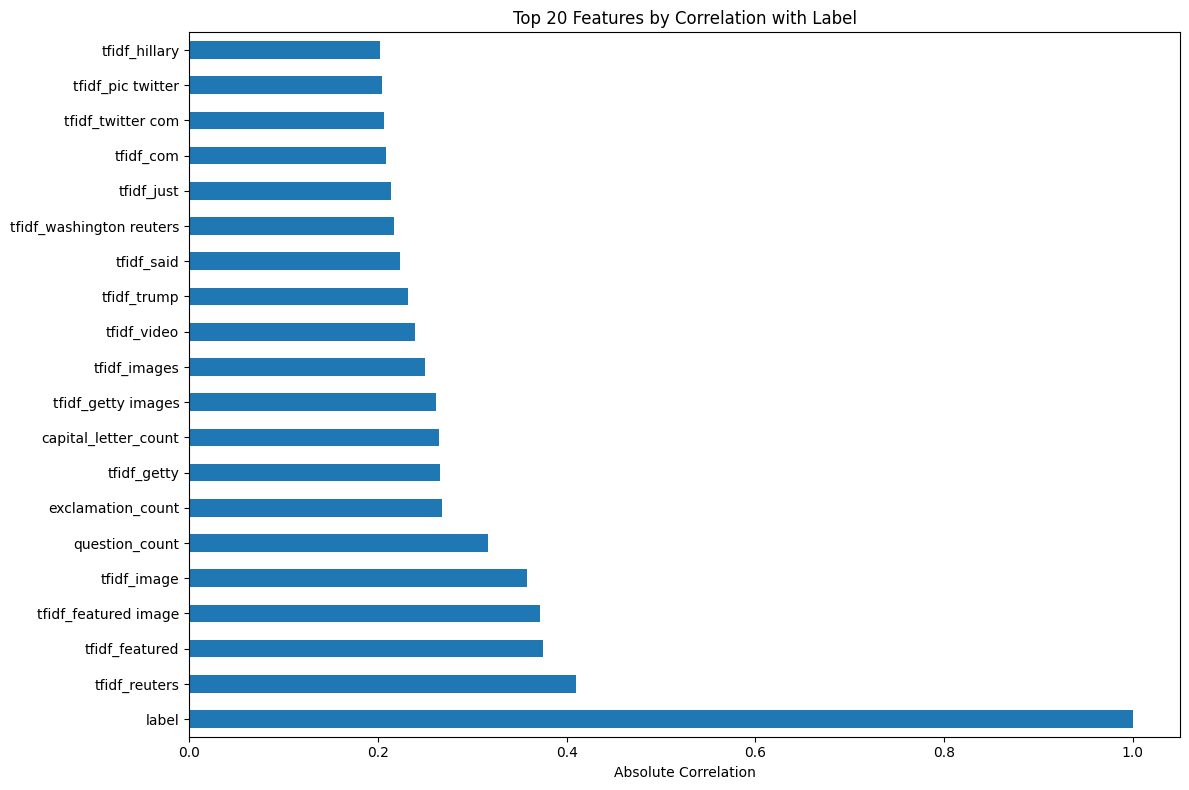

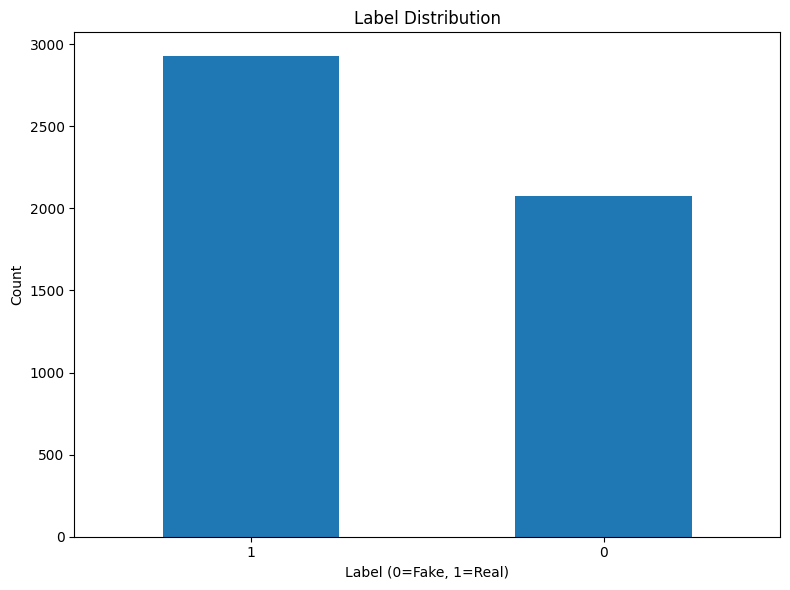

<Figure size 1000x600 with 0 Axes>

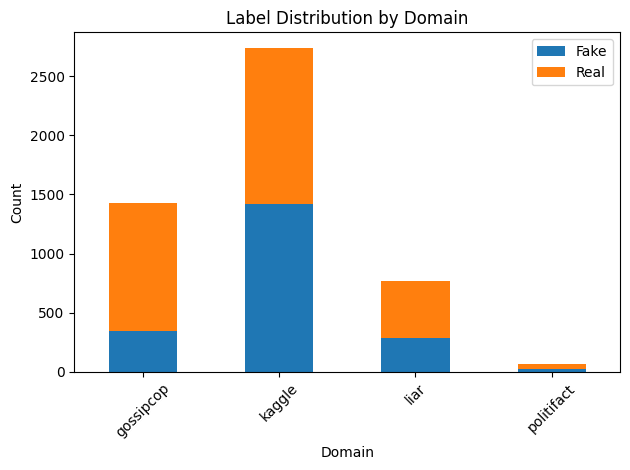

✓ All processed data saved successfully!
  - Training data: /home/ghost/fake-news-game-theory/data/processed/train/
  - Validation data: /home/ghost/fake-news-game-theory/data/processed/validation/
  - Test data: /home/ghost/fake-news-game-theory/data/processed/test/
  - Features and metadata: /home/ghost/fake-news-game-theory/data/processed/features/

FEATURE ENGINEERING SUMMARY
Total samples processed: 5,000
Total features created: 2,031
  - Linguistic features: 31
  - TF-IDF features: 2,000

Data splits:
  - Training: 3,500 samples
  - Validation: 500 samples
  - Test: 1,000 samples

Class distribution (Fake=0, Real=1):
  - Train: 1,452 fake (41.5%), 2,048 real (58.5%)
  - Val: 207 fake (41.4%), 293 real (58.6%)
  - Test: 415 fake (41.5%), 585 real (58.5%)


In [30]:
def analyze_features(features_df):
    """Analyze feature distributions and correlations"""
    
    print("Feature Analysis:")
    
    # Basic statistics
    numeric_features = features_df.select_dtypes(include=[np.number])
    print(f"Number of numeric features: {len(numeric_features.columns)}")
    
    # Feature correlation with target
    correlations = numeric_features.corrwith(features_df['label']).abs().sort_values(ascending=False)
    print("\nTop 20 features correlated with label:")
    print(correlations.head(20))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    correlations.head(20).plot(kind='barh')
    plt.title('Top 20 Features by Correlation with Label')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.savefig(os.path.join(PROCESSED_PATH, 'features', 'feature_correlations.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Label distribution
    plt.figure(figsize=(8, 6))
    features_df['label'].value_counts().plot(kind='bar')
    plt.title('Label Distribution')
    plt.xlabel('Label (0=Fake, 1=Real)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(PROCESSED_PATH, 'features', 'label_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Domain distribution
    if 'domain' in features_df.columns:
        plt.figure(figsize=(10, 6))
        domain_label_crosstab = pd.crosstab(features_df['domain'], features_df['label'])
        domain_label_crosstab.plot(kind='bar', stacked=True)
        plt.title('Label Distribution by Domain')
        plt.xlabel('Domain')
        plt.ylabel('Count')
        plt.legend(['Fake', 'Real'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(PROCESSED_PATH, 'features', 'domain_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    return correlations

if len(final_features) > 0:
    feature_correlations = analyze_features(final_features)

## 8. Save Processed Data

def save_processed_data(data_splits, features_df, additional_objects=None):
    """Save all processed data and objects"""
    
    # Save train/val/test splits
    data_splits['X_train'].to_csv(os.path.join(PROCESSED_PATH, 'train', 'X_train.csv'), index=False)
    data_splits['y_train'].to_csv(os.path.join(PROCESSED_PATH, 'train', 'y_train.csv'), index=False)
    
    data_splits['X_val'].to_csv(os.path.join(PROCESSED_PATH, 'validation', 'X_val.csv'), index=False)
    data_splits['y_val'].to_csv(os.path.join(PROCESSED_PATH, 'validation', 'y_val.csv'), index=False)
    
    data_splits['X_test'].to_csv(os.path.join(PROCESSED_PATH, 'test', 'X_test.csv'), index=False)
    data_splits['y_test'].to_csv(os.path.join(PROCESSED_PATH, 'test', 'y_test.csv'), index=False)
    
    # Save complete feature dataset
    features_df.to_csv(os.path.join(PROCESSED_PATH, 'features', 'all_features.csv'), index=False)
    
    # Save preprocessing objects
    with open(os.path.join(PROCESSED_PATH, 'features', 'scaler.pkl'), 'wb') as f:
        pickle.dump(data_splits['scaler'], f)
    
    # Save feature names
    with open(os.path.join(PROCESSED_PATH, 'features', 'feature_names.pkl'), 'wb') as f:
        pickle.dump(data_splits['feature_names'], f)
    
    # Save TF-IDF vectorizer if available
    if additional_objects and 'tfidf_vectorizer' in additional_objects:
        with open(os.path.join(PROCESSED_PATH, 'features', 'tfidf_vectorizer.pkl'), 'wb') as f:
            pickle.dump(additional_objects['tfidf_vectorizer'], f)
    
    # Save feature analysis results
    if additional_objects and 'feature_correlations' in additional_objects:
        additional_objects['feature_correlations'].to_csv(
            os.path.join(PROCESSED_PATH, 'features', 'feature_correlations.csv')
        )

     # Create feature summary (continuing from the incomplete section)
    feature_summary = {
        'total_samples': len(features_df),
        'total_features': len(data_splits['feature_names']),
        'train_samples': len(data_splits['X_train']),
        'val_samples': len(data_splits['X_val']),
        'test_samples': len(data_splits['X_test']),
        'feature_types': {
            'linguistic_features': len([col for col in data_splits['feature_names'] if 'tfidf' not in col]),
            'tfidf_features': len([col for col in data_splits['feature_names'] if 'tfidf' in col])
        },
        'class_distribution': {
            'train': data_splits['y_train'].value_counts().to_dict(),
            'val': data_splits['y_val'].value_counts().to_dict(),
            'test': data_splits['y_test'].value_counts().to_dict()
        }
    }
    
    # Save feature summary as JSON
    import json
    with open(os.path.join(PROCESSED_PATH, 'features', 'feature_summary.json'), 'w') as f:
        json.dump(feature_summary, f, indent=2)
    
    print("✓ All processed data saved successfully!")
    print(f"  - Training data: {PROCESSED_PATH}/train/")
    print(f"  - Validation data: {PROCESSED_PATH}/validation/")
    print(f"  - Test data: {PROCESSED_PATH}/test/")
    print(f"  - Features and metadata: {PROCESSED_PATH}/features/")
    
    return feature_summary

# Save all processed data
if len(final_features) > 0:
    additional_objects = {
        'tfidf_vectorizer': tfidf_vectorizer,
        'feature_correlations': feature_correlations
    }
    
    feature_summary = save_processed_data(
        data_splits, 
        final_features, 
        additional_objects
    )
    
    print("\n" + "="*50)
    print("FEATURE ENGINEERING SUMMARY")
    print("="*50)
    print(f"Total samples processed: {feature_summary['total_samples']:,}")
    print(f"Total features created: {feature_summary['total_features']:,}")
    print(f"  - Linguistic features: {feature_summary['feature_types']['linguistic_features']:,}")
    print(f"  - TF-IDF features: {feature_summary['feature_types']['tfidf_features']:,}")
    
    print(f"\nData splits:")
    print(f"  - Training: {feature_summary['train_samples']:,} samples")
    print(f"  - Validation: {feature_summary['val_samples']:,} samples")
    print(f"  - Test: {feature_summary['test_samples']:,} samples")
    
    print(f"\nClass distribution (Fake=0, Real=1):")
    for split_name, distribution in feature_summary['class_distribution'].items():
        fake_count = distribution.get(0, 0)
        real_count = distribution.get(1, 0)
        total = fake_count + real_count
        if total > 0:
            fake_pct = (fake_count / total) * 100
            real_pct = (real_count / total) * 100
            print(f"  - {split_name.capitalize()}: {fake_count:,} fake ({fake_pct:.1f}%), {real_count:,} real ({real_pct:.1f}%)")

In [31]:
## 9. Additional Feature Engineering Functions

def create_word_clouds(features_df, save_path):
    """Create word clouds for fake vs real news"""
    
    print("Creating word clouds...")
    
    # Separate fake and real news text
    fake_text = ' '.join(features_df[features_df['label'] == 0]['text'].dropna().astype(str))
    real_text = ' '.join(features_df[features_df['label'] == 1]['text'].dropna().astype(str))
    
    # Create word clouds
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Fake news word cloud
    if fake_text.strip():
        fake_wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            max_words=100,
            colormap='Reds'
        ).generate(fake_text)
        
        axes[0].imshow(fake_wordcloud, interpolation='bilinear')
        axes[0].set_title('Fake News Word Cloud', fontsize=16, fontweight='bold')
        axes[0].axis('off')
    
    # Real news word cloud
    if real_text.strip():
        real_wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            max_words=100,
            colormap='Blues'
        ).generate(real_text)
        
        axes[1].imshow(real_wordcloud, interpolation='bilinear')
        axes[1].set_title('Real News Word Cloud', fontsize=16, fontweight='bold')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'word_clouds.png'), dpi=300, bbox_inches='tight')
    plt.show()


In [32]:
def create_feature_distribution_plots(features_df, save_path):
    """Create distribution plots for key features"""
    
    print("Creating feature distribution plots...")
    
    # Select key linguistic features for visualization
    key_features = [
        'word_count', 'avg_word_length', 'sentiment_compound',
        'readability_score', 'exclamation_count', 'capital_letter_count'
    ]
    
    # Filter to existing features
    available_features = [f for f in key_features if f in features_df.columns]
    
    if len(available_features) >= 4:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, feature in enumerate(available_features[:6]):
            if i < len(axes):
                # Create distribution plots for fake vs real
                fake_data = features_df[features_df['label'] == 0][feature]
                real_data = features_df[features_df['label'] == 1][feature]
                
                axes[i].hist(fake_data, alpha=0.7, label='Fake', bins=30, color='red')
                axes[i].hist(real_data, alpha=0.7, label='Real', bins=30, color='blue')
                axes[i].set_title(f'{feature.replace("_", " ").title()} Distribution')
                axes[i].set_xlabel(feature.replace("_", " ").title())
                axes[i].set_ylabel('Frequency')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(available_features), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, 'feature_distributions.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [33]:
def create_correlation_heatmap(features_df, save_path):
    """Create correlation heatmap for top features"""
    
    print("Creating correlation heatmap...")
    
    # Select numeric features (excluding TF-IDF for readability)
    numeric_features = features_df.select_dtypes(include=[np.number])
    non_tfidf_features = [col for col in numeric_features.columns 
                         if 'tfidf' not in col and col != 'label']
    
    if len(non_tfidf_features) > 0:
        # Add label for correlation analysis
        correlation_features = non_tfidf_features + ['label']
        correlation_matrix = features_df[correlation_features].corr()
        
        # Create heatmap
        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        sns.heatmap(
            correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8}
        )
        
        plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
        plt.show()

Creating word clouds...


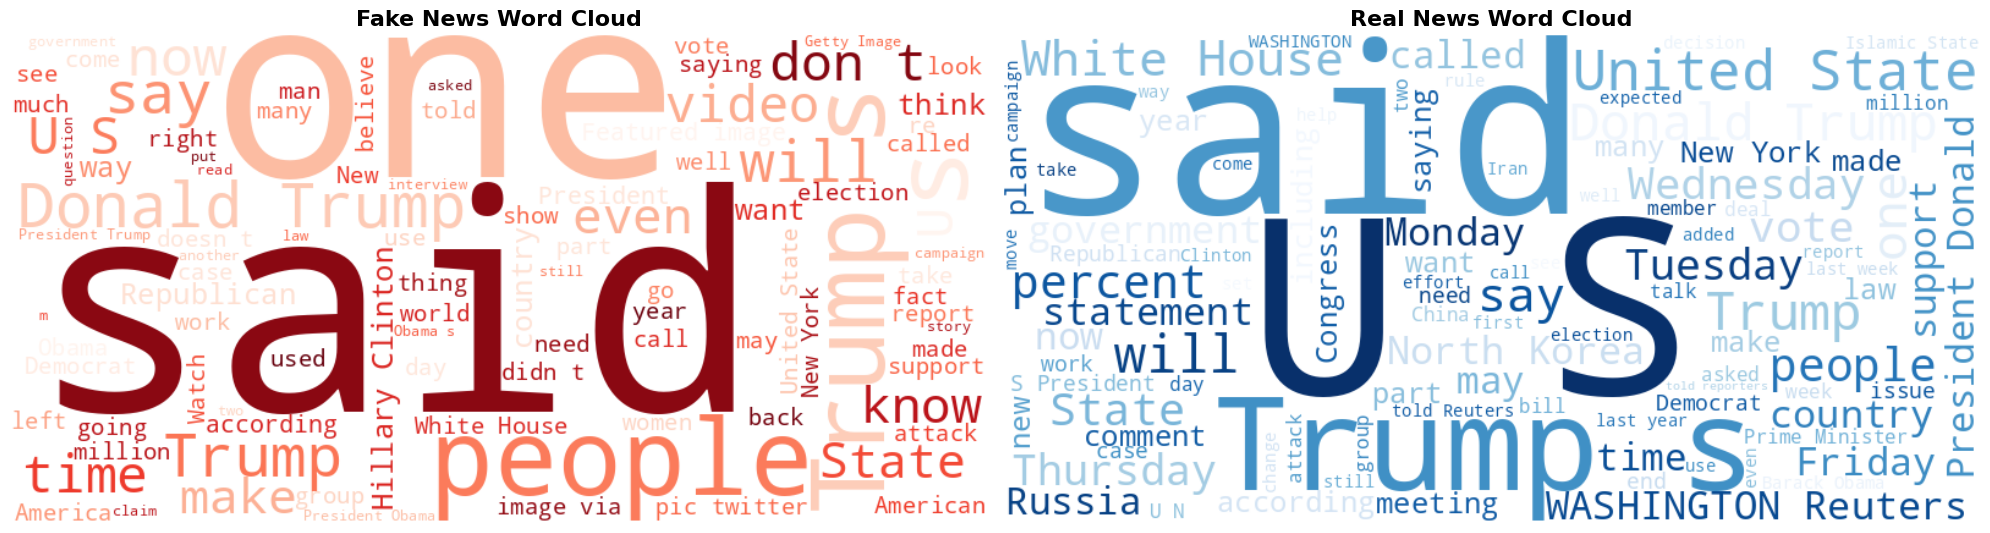

Creating feature distribution plots...


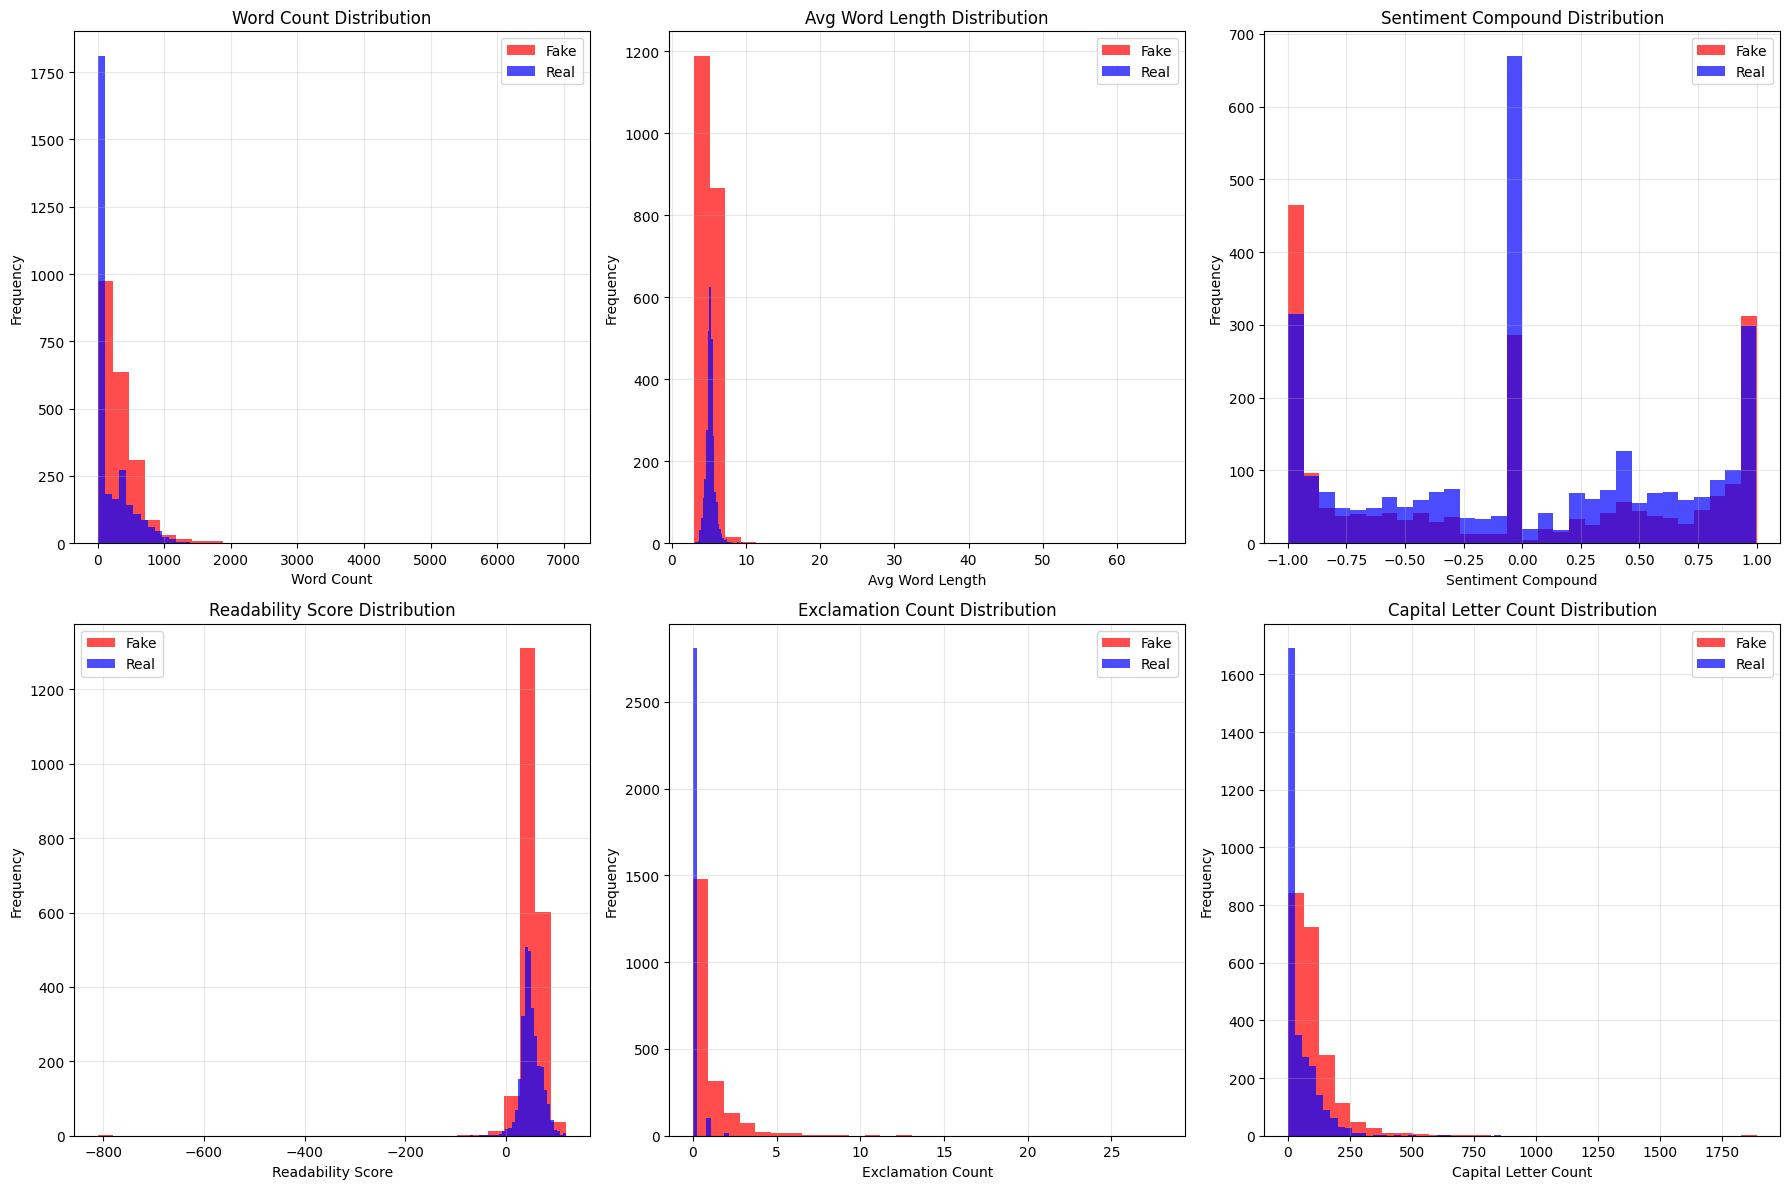

Creating correlation heatmap...


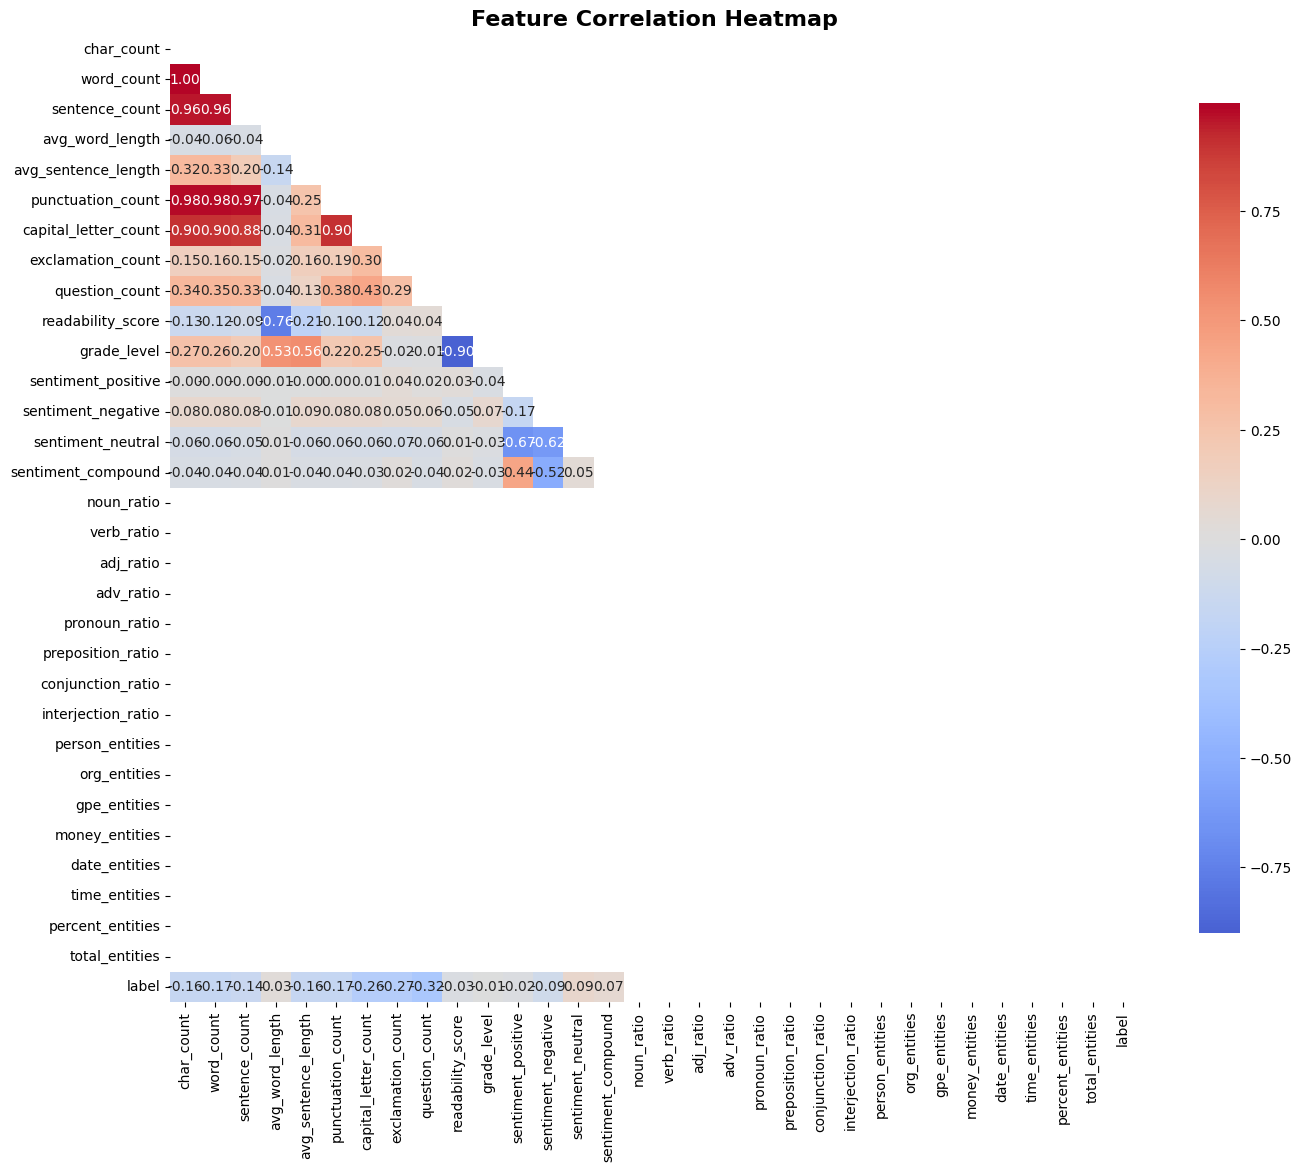

Selecting top 100 features...
Selected 100 features for modeling
Top 10 selected features:
   1. tfidf_reuters: 0.4095
   2. tfidf_featured: 0.3749
   3. tfidf_featured image: 0.3720
   4. tfidf_image: 0.3580
   5. question_count: 0.3164
   6. exclamation_count: 0.2677
   7. tfidf_getty: 0.2662
   8. capital_letter_count: 0.2650
   9. tfidf_getty images: 0.2613
  10. tfidf_images: 0.2500


In [34]:
# Create additional visualizations if data is available
if len(final_features) > 0:
    viz_save_path = os.path.join(PROCESSED_PATH, 'features')
    
    # Only create word clouds if we have text data
    if 'text' in combined_features.columns:
        try:
            create_word_clouds(combined_features, viz_save_path)
        except Exception as e:
            print(f"Warning: Could not create word clouds: {e}")
    
    # Create feature distribution plots
    try:
        create_feature_distribution_plots(final_features, viz_save_path)
    except Exception as e:
        print(f"Warning: Could not create distribution plots: {e}")
    
    # Create correlation heatmap
    try:
        create_correlation_heatmap(final_features, viz_save_path)
    except Exception as e:
        print(f"Warning: Could not create correlation heatmap: {e}")

## 10. Feature Selection and Final Recommendations

def select_top_features(features_df, correlations, top_k=100):
    """Select top features based on correlation with target"""
    
    print(f"Selecting top {top_k} features...")
    
    # Get top correlated features (excluding label)
    top_features = correlations.drop('label', errors='ignore').head(top_k).index.tolist()
    
    # Always include the label
    selected_columns = top_features + ['label']
    
    # Add domain if available for stratification
    if 'domain' in features_df.columns:
        selected_columns.append('domain')
    
    selected_features_df = features_df[selected_columns]
    
    print(f"Selected {len(top_features)} features for modeling")
    print("Top 10 selected features:")
    for i, feature in enumerate(top_features[:10], 1):
        corr_value = correlations[feature]
        print(f"  {i:2d}. {feature}: {corr_value:.4f}")
    
    # Save selected features
    selected_features_df.to_csv(
        os.path.join(PROCESSED_PATH, 'features', 'selected_features.csv'), 
        index=False
    )
    
    with open(os.path.join(PROCESSED_PATH, 'features', 'selected_feature_names.pkl'), 'wb') as f:
        pickle.dump(top_features, f)
    
    return selected_features_df, top_features

# Select top features for modeling
if len(final_features) > 0 and 'feature_correlations' in locals():
    selected_features_df, selected_feature_names = select_top_features(
        final_features, 
        feature_correlations, 
        top_k=100
    )

In [ ]:
## 11. Pipeline Validation and Quality Checks

def validate_feature_pipeline():
    """Validate the feature engineering pipeline"""
    
    print("\n" + "="*50)
    print("PIPELINE VALIDATION")
    print("="*50)
    
    checks_passed = 0
    total_checks = 0
    
    # Check 1: Data files exist
    total_checks += 1
    required_files = [
        'train/X_train.csv', 'train/y_train.csv',
        'validation/X_val.csv', 'validation/y_val.csv',
        'test/X_test.csv', 'test/y_test.csv',
        'features/all_features.csv',
        'features/scaler.pkl',
        'features/feature_names.pkl'
    ]
    
    missing_files = []
    for file_path in required_files:
        full_path = os.path.join(PROCESSED_PATH, file_path)
        if not os.path.exists(full_path):
            missing_files.append(file_path)
    
    if not missing_files:
        print("✓ All required files created successfully")
        checks_passed += 1
    else:
        print(f"✗ Missing files: {missing_files}")
    
    # Check 2: Data integrity
    total_checks += 1
    try:
        # Load and check data shapes
        X_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train/X_train.csv'))
        y_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train/y_train.csv'))
        
        if len(X_train) == len(y_train) and len(X_train) > 0:
            print(f"✓ Data integrity check passed - {len(X_train)} training samples")
            checks_passed += 1
        else:
            print("✗ Data integrity check failed - mismatched dimensions")
    except Exception as e:
        print(f"✗ Data integrity check failed: {e}")
    
    # Check 3: Feature diversity - Check the actual saved files
    total_checks += 1
    try:
        X_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train/X_train.csv'))
        feature_count = len(X_train.columns)
        
        if feature_count >= 50:  # Minimum expected features
            print(f"✓ Feature diversity check passed - {feature_count} features created")
            checks_passed += 1
        else:
            print(f"✗ Feature diversity check failed - only {feature_count} features")
    except Exception as e:
        print(f"✗ Feature diversity check failed: {e}")
    
    # Check 4: Class balance - Check the actual saved files
    total_checks += 1
    try:
        y_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train/y_train.csv'))
        train_balance = y_train.iloc[:, 0].value_counts()  # First column contains labels
        minority_ratio = min(train_balance) / sum(train_balance)
        
        if minority_ratio >= 0.1:  # At least 10% minority class
            print(f"✓ Class balance check passed - minority class: {minority_ratio:.2%}")
            checks_passed += 1
        else:
            print(f"✗ Class balance check failed - minority class: {minority_ratio:.2%}")
    except Exception as e:
        print(f"✗ Class balance check failed: {e}")
    
    # Final validation summary
    print(f"\nValidation Summary: {checks_passed}/{total_checks} checks passed")
    
    if checks_passed == total_checks:
        print("🎉 Feature engineering pipeline completed successfully!")
        print("Ready for model training and evaluation.")
    else:
        print("⚠️  Pipeline completed with warnings. Review failed checks.")
    
    return checks_passed == total_checks

# Run pipeline validation
pipeline_success = validate_feature_pipeline()

In [ ]:
# Final Pipeline Test - Load saved data and verify model-readiness
print("="*60)
print("PIPELINE COMPLETENESS TEST")
print("="*60)

def test_pipeline_completeness():
    """Test if the pipeline is complete and ready for modeling"""
    
    try:
        # Load training data
        X_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train/X_train.csv'))
        y_train = pd.read_csv(os.path.join(PROCESSED_PATH, 'train/y_train.csv'))
        
        # Load validation data  
        X_val = pd.read_csv(os.path.join(PROCESSED_PATH, 'validation/X_val.csv'))
        y_val = pd.read_csv(os.path.join(PROCESSED_PATH, 'validation/y_val.csv'))
        
        # Load test data
        X_test = pd.read_csv(os.path.join(PROCESSED_PATH, 'test/X_test.csv'))
        y_test = pd.read_csv(os.path.join(PROCESSED_PATH, 'test/y_test.csv'))
        
        print(f"✓ Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
        print(f"✓ Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")
        print(f"✓ Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
        
        # Check class distributions
        y_train_dist = y_train.iloc[:, 0].value_counts().sort_index()
        y_val_dist = y_val.iloc[:, 0].value_counts().sort_index()
        y_test_dist = y_test.iloc[:, 0].value_counts().sort_index()
        
        print(f"✓ Training classes: {y_train_dist.to_dict()}")
        print(f"✓ Validation classes: {y_val_dist.to_dict()}")  
        print(f"✓ Test classes: {y_test_dist.to_dict()}")
        
        # Check for minimum feature count
        min_features = 50
        if X_train.shape[1] >= min_features:
            print(f"✓ Feature diversity: {X_train.shape[1]} features (>= {min_features})")
        else:
            print(f"❌ Feature diversity: Only {X_train.shape[1]} features (< {min_features})")
            return False
            
        # Check class balance
        minority_ratio = min(y_train_dist) / sum(y_train_dist)
        if minority_ratio >= 0.1:
            print(f"✓ Class balance: {minority_ratio:.1%} minority class")
        else:
            print(f"❌ Class balance: {minority_ratio:.1%} minority class (< 10%)")
            return False
            
        print("\n🎉 PIPELINE COMPLETE AND READY FOR MODEL TRAINING!")
        print(f"📊 Dataset Summary:")
        print(f"   • Total samples: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,}")
        print(f"   • Total features: {X_train.shape[1]:,}")
        print(f"   • Train/Val/Test split: {X_train.shape[0]}/{X_val.shape[0]}/{X_test.shape[0]}")
        
        return True
        
    except Exception as e:
        print(f"❌ Pipeline test failed: {e}")
        return False

# Run the test
pipeline_ready = test_pipeline_completeness()

In [36]:
## 12. Next Steps and Recommendations

print("\n" + "="*60)
print("NEXT STEPS FOR FAKE NEWS DETECTION PROJECT")
print("="*60)

recommendations = [
    "1. MODEL DEVELOPMENT:",
    "   • Train baseline models (Logistic Regression, Random Forest)",
    "   • Experiment with advanced models (XGBoost, Neural Networks)",
    "   • Use cross-validation for robust evaluation",
    "",
    "2. FEATURE OPTIMIZATION:",
    "   • Perform recursive feature elimination",
    "   • Try different TF-IDF parameters (n-grams, max_features)",
    "   • Consider additional linguistic features (dependency parsing)",
    "",
    "3. GAME THEORY INTEGRATION:",
    "   • Model publisher-reader interactions",
    "   • Implement strategic classification frameworks",
    "   • Analyze equilibrium conditions in news ecosystems",
    "",
    "4. EVALUATION STRATEGIES:",
    "   • Use multiple metrics (precision, recall, F1, AUC)",
    "   • Analyze performance by domain and source",
    "   • Test on out-of-distribution data",
    "",
    "5. DEPLOYMENT CONSIDERATIONS:",
    "   • Create inference pipeline with feature extraction",
    "   • Implement real-time prediction API",
    "   • Monitor model performance and drift"
]

for rec in recommendations:
    print(rec)

print("\n" + "="*60)
print("FEATURE ENGINEERING PIPELINE COMPLETE")
print("="*60)

# Create a final status report
if 'feature_summary' in locals():
    status_report = {
        "pipeline_status": "COMPLETED" if pipeline_success else "COMPLETED_WITH_WARNINGS",
        "timestamp": pd.Timestamp.now().isoformat(),
        "summary": feature_summary,
        "next_steps": "Ready for model training phase"
    }
    
    with open(os.path.join(PROCESSED_PATH, 'pipeline_status.json'), 'w') as f:
        json.dump(status_report, f, indent=2)
    
    print(f"Status report saved to: {PROCESSED_PATH}/pipeline_status.json")


NEXT STEPS FOR FAKE NEWS DETECTION PROJECT
1. MODEL DEVELOPMENT:
   • Train baseline models (Logistic Regression, Random Forest)
   • Experiment with advanced models (XGBoost, Neural Networks)
   • Use cross-validation for robust evaluation

2. FEATURE OPTIMIZATION:
   • Perform recursive feature elimination
   • Try different TF-IDF parameters (n-grams, max_features)
   • Consider additional linguistic features (dependency parsing)

3. GAME THEORY INTEGRATION:
   • Model publisher-reader interactions
   • Implement strategic classification frameworks
   • Analyze equilibrium conditions in news ecosystems

4. EVALUATION STRATEGIES:
   • Use multiple metrics (precision, recall, F1, AUC)
   • Analyze performance by domain and source
   • Test on out-of-distribution data

5. DEPLOYMENT CONSIDERATIONS:
   • Create inference pipeline with feature extraction
   • Implement real-time prediction API
   • Monitor model performance and drift

FEATURE ENGINEERING PIPELINE COMPLETE
Status report 

In [37]:
# Test JSON import 
import json
print("JSON module imported successfully!")

JSON module imported successfully!
